# 2) Applied Question
## Modeling High or Low Gas Mileage

For this second applied question you will develop several predictive models. These should be written in R or Python and the code should be submitted. The models will predict whether a car will get high or low gas mileage. The question will be based on the Cars_mileage data set that is a part of this repo.

March 19, 2017

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import seaborn as sns
import numpy as np
import csv
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
#Importing specific scikitlearn modules
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import ParameterGrid, StratifiedKFold
from sklearn.metrics import *

## Supplemental Analysis

In the following sections, I walk through some preliminary analysis required to answer the provided questions.
- Supplemental 1: Preliminary Data Exploration
    - Includes descriptive statistics, visualization of distributions, and checking for null values.
- Supplemental 2: Cleaning and Imputation
    - I create separate columns for the make and models and impute missing values in the ***horsepower*** column.
- Supplemental 3: General Description of Data & Assumptions
    - After I perform the initial exploration and cleaning, I provide a high level overview of the data and my assumptions.

### Supplemental 1: Preliminary Data Exploration

In [2]:
# Read in CSV. Get row count and number of unique makes & models. Examine first few rows.

df = pd.read_csv("Cars_mileage.csv")
unique_cars = sorted(list(df.name.unique()))
print("The total number of rows in this dataset: {}".format(len(df)))
print("The number of unique car make & models: {}".format(len(unique_cars)))
df.head()

The total number of rows in this dataset: 397
The number of unique car make & models: 304


,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


In [3]:
# Top 10 most popular cars
df['name'].value_counts().head(10)

ford pinto            6
amc matador           5
ford maverick         5
toyota corolla        5
chevrolet impala      4
toyota corona         4
peugeot 504           4
amc hornet            4
amc gremlin           4
chevrolet chevette    4
Name: name, dtype: int64

In [4]:
# Top 10 most efficient cars. Note the '?' in the horsepower column.
df.sort_values('mpg', ascending=False).head(10)

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
322,46.6,4,86.0,65,2110,17.9,80,3,mazda glc
329,44.6,4,91.0,67,1850,13.8,80,3,honda civic 1500 gl
325,44.3,4,90.0,48,2085,21.7,80,2,vw rabbit c (diesel)
393,44.0,4,97.0,52,2130,24.6,82,2,vw pickup
326,43.4,4,90.0,48,2335,23.7,80,2,vw dasher (diesel)
244,43.1,4,90.0,48,1985,21.5,78,2,volkswagen rabbit custom diesel
309,41.5,4,98.0,76,2144,14.7,80,2,vw rabbit
330,40.9,4,85.0,?,1835,17.3,80,2,renault lecar deluxe
324,40.8,4,85.0,65,2110,19.2,80,3,datsun 210
247,39.4,4,85.0,70,2070,18.6,78,3,datsun b210 gx


In [5]:
# Get descriptive statistics for dataframe
df.describe()

,mpg,cylinders,displacement,weight,acceleration,year,origin
count,397.000000,397.000000,397.000000,397.000000,397.000000,397.000000,397.000000
mean,23.515869,5.458438,193.532746,2970.261965,15.555668,75.994962,1.574307
std,7.825804,1.701577,104.379583,847.904119,2.749995,3.690005,0.802549
min,9.000000,3.000000,68.000000,1613.000000,8.000000,70.000000,1.000000
25%,17.500000,4.000000,104.000000,2223.000000,13.800000,73.000000,1.000000
50%,23.000000,4.000000,146.000000,2800.000000,15.500000,76.000000,1.000000
75%,29.000000,8.000000,262.000000,3609.000000,17.100000,79.000000,2.000000
max,46.600000,8.000000,455.000000,5140.000000,24.800000,82.000000,3.000000


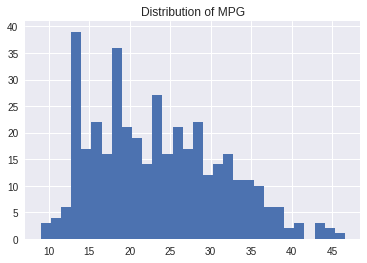

In [6]:
# Since we are interested in mpg specifically, let's look at its distribution.
ax = df['mpg'].hist(bins=30)
ax.set_title('Distribution of MPG')

In [7]:
# Get unique values for categorical variables
print("Unique Values for Categorical Variables\n")
print('origins: ' + str(sorted(df['origin'].unique())))
print('years: ' + str(sorted(df['year'].unique())))
print('cylinders: ' + str(sorted(df['cylinders'].unique())))

Unique Values for Categorical Variables

origins: [1, 2, 3]
years: [70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82]
cylinders: [3, 4, 5, 6, 8]


In [8]:
## Doing a preliminary check for nulls
df.isnull().sum()

mpg             0
cylinders       0
displacement    0
horsepower      0
weight          0
acceleration    0
year            0
origin          0
name            0
dtype: int64

### Supplemental 2: Data Cleaning & Imputation

In this section I create a cleaned dataframe (*clean_df*) to be used for modeling. To do so, I clean up a few issues with the data. 

First, horsepower has a few missing values denoted in the dataset with *'?'*. Because of the use of this character, Pandas has interpeted the data type of this column as "object" types. I will convert this column to a numerical value and then impute the missing values with the median horsepower.

Secondly, car makes don't look to be standardized. In this section, I'll manually create a dictionary of definitive make names, and replace the erroneous makes with the standard ones. Then I add three new columns to *clean_df* for the make, basic model, and full model.

In [9]:
# First, I convert any object types to numerical values. Then I check for nulls.
clean_df = df.copy().convert_objects(convert_numeric=True)
clean_df.isnull().sum()

mpg             0
cylinders       0
displacement    0
horsepower      5
weight          0
acceleration    0
year            0
origin          0
name            0
dtype: int64

#### Imputation
It appears that ***horsepower*** is missing 5 values. Here, I'll impute it with the median.
Other common optionos are '0' or the mean. In this case, 0 doesn't seem to be a useful value for imputation since it's impossible for a car to have 0 horsepower. Additionally, the distribution shows that horsepower is somewhat normally distributed, but has a long tail, pulling the mean to the right. Therefore, we'll use the median as the imputation value to be safe.

count    392.000000
mean     104.469388
std       38.491160
min       46.000000
25%       75.000000
50%       93.500000
75%      126.000000
max      230.000000
Name: horsepower, dtype: float64


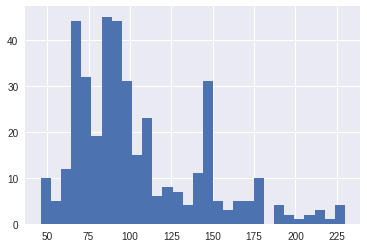

In [10]:
clean_df['horsepower'].hist(bins=30)
print(clean_df['horsepower'].describe())
hp_median = clean_df['horsepower'].median()
clean_df['horsepower']=clean_df['horsepower'].fillna(value=hp_median)

#### Extracting Makes and Models
Here, I manually create a dictionary of erroneous ***make*** names to ones I've standardized through inspection and my own general knowledge.
Then, I use Pandas' apply function to create a new column for the ***make***, 
***basic_model***, and ***full_model***. I try to capture the essential model information in
***basic_model***, e.g. whether or not it is a Camry or a Rabbit. The column ***full_model*** will capture all of the model information, including model class and trim level.

In [11]:
to_remove = {'vw': 'volkswagen', 
             'vokswagen':'volkswagen', 
             'maxda':'mazda', 
             'mercedes':'mercedes-benz', 
             'chevy':'chevrolet', 
             'chevroelt':'chevrolet', 
             'toyouta':'toyota'}

def cleanMake(x):
    '''
    Takes a string and returns the first element of the string separated by spaces.
    '''
    make = x.split(' ')[0]
    if make in to_remove.keys():
        return to_remove[make]
    return make

def cleanModel(x, basic=True):
    '''    
    Takes a string.
    If basic is true, returns the second element of the string separated by spaces.
    Otherwise, it returns everything after the first element of the string.
    '''
    try:
        if basic:
            return x.split(' ')[1]
        else:
            return ' '.join(x.split(' ')[1:])
    except:
        return ''

clean_df['make'] = clean_df['name'].apply(cleanMake)
clean_df['basic_model'] = clean_df['name'].apply(cleanModel)
clean_df['full_model'] = clean_df['name'].apply(cleanModel, args=(False,))

print('Unique Makes: {}'.format(len(list(clean_df['make'].unique()))))
print(list(clean_df['make'].unique()))
print()
print('Unique Basic Models: {}'.format(len(list(clean_df['basic_model'].unique()))))
print(list(clean_df['basic_model'].unique()))
print()
print('Unique Full Models: {}'.format(len(list(clean_df['full_model'].unique()))))
print(list(clean_df['full_model'].unique()))
print()
clean_df.head()

Unique Makes: 30
['chevrolet', 'buick', 'plymouth', 'amc', 'ford', 'pontiac', 'dodge', 'toyota', 'datsun', 'volkswagen', 'peugeot', 'audi', 'saab', 'bmw', 'hi', 'mercury', 'opel', 'fiat', 'oldsmobile', 'chrysler', 'mazda', 'volvo', 'renault', 'honda', 'subaru', 'capri', 'mercedes-benz', 'cadillac', 'triumph', 'nissan']

Unique Basic Models: 190
['chevelle', 'skylark', 'satellite', 'rebel', 'torino', 'galaxie', 'impala', 'fury', 'catalina', 'ambassador', 'challenger', "'cuda", 'monte', 'estate', 'corona', 'duster', 'hornet', 'maverick', 'pl510', '1131', '504', '100', '99e', '2002', 'gremlin', 'f250', 'c20', 'd200', '1200d', 'vega', 'pinto', 'matador', 'monaco', 'country', 'safari', 'firebird', 'mustang', 'capri', '1900', '304', '124b', 'corolla', '1200', 'model', 'cricket', 'colt', 'type', 'marquis', 'lesabre', 'delta', 'newport', 'rx2', 'gran', '145e', '411', '12', '510', 'century', 'malibu', 'coronet', 'caprice', 'ltd', 'new', 'electra', 'valiant', 'nova', 'super', 'custom', 'vista', 

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name,make,basic_model,full_model
0,18.0,8,307.0,130.0,3504,12.0,70,1,chevrolet chevelle malibu,chevrolet,chevelle,chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,1,buick skylark 320,buick,skylark,skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,1,plymouth satellite,plymouth,satellite,satellite
3,16.0,8,304.0,150.0,3433,12.0,70,1,amc rebel sst,amc,rebel,rebel sst
4,17.0,8,302.0,140.0,3449,10.5,70,1,ford torino,ford,torino,torino


### Supplemental 3: General Description of Data & Assumptions
There are 397 rows in this dataset, representing 30 unique makes and 299 unique models & classes. There appear to be no null values. Each row is represented by 9 columns:

Column Name | Variable Type | Data Type | Description
-----|-----|-----|----
mpg | continuous | float | Miles per Gallon. Min is 9 mpg, max is 46.6 mpg, mean and median are 23.5 and 23 mpg respectively
cylinders | discrete/categorical | int | Ranges from 3-8 cylinders, with most cars having 4.
displacement | continuous | float | The total volume of the cylinders. Min is 68, max is 455. Mean and median are 193.5 and 146, respectively. I'm assuming cc units.
horsepower | continuous | float | The power of the engine. Min is 46, max is 230, mean and median are 104 and 93.5, respectively.
weight | continuous | int | Cars weigh between 1613-5140, I'm assuming in pounds.
acceleration | continuous | float | Min is 8, max is 24.8, mean and median are 15.6 and 15.5, respectively.
year | discrete/categorical | int | The cars were made in the years spanning 1970 - 1982
origin | discrete/categorical | int | There are three origins - 1, 2, and 3. I'm asuming these are categorical, i.e. the numbers are not ordinal.
name | discrete/categorical | string | The make and model. There are 304 unique strings for 397 rows.

In addition to these, I've added three new categorical variables as strings: ***make***, ***basic_model***, and ***full_model***.

The 5 most popular vehicles in this dataset are the Ford Pinto, AMC Matador, Toyota Corolla, Ford Maverick, and Chevorlet Impala. A 1980 Mazda GLC is the most efficeint at 46.6 miles per gallon. 

## Part A
Create a binary variable that represents whether the car's mpg is above or below its median. Above the median should be represented as 1. Name this variable mpg_binary.

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name,make,basic_model,full_model,mpg_binary
0,18.0,8,307.0,130.0,3504,12.0,70,1,chevrolet chevelle malibu,chevrolet,chevelle,chevelle malibu,0
1,15.0,8,350.0,165.0,3693,11.5,70,1,buick skylark 320,buick,skylark,skylark 320,0
2,18.0,8,318.0,150.0,3436,11.0,70,1,plymouth satellite,plymouth,satellite,satellite,0
3,16.0,8,304.0,150.0,3433,12.0,70,1,amc rebel sst,amc,rebel,rebel sst,0
4,17.0,8,302.0,140.0,3449,10.5,70,1,ford torino,ford,torino,torino,0


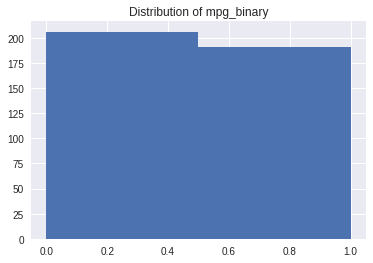

In [12]:
median = clean_df['mpg'].median()
clean_df['mpg_binary'] = ((df['mpg'] > median) * 1)
ax = clean_df['mpg_binary'].hist(bins=2)
ax.set_title("Distribution of mpg_binary")
clean_df.head()

## Part B
Which of the other variables seem most likely to be useful in predicting whether a car's mpg is above or below its median? Describe your findings and submit visual representations of the relationship between mpg_binary and other variables.

### Correlation
If we look at the correlation table and matrix for non-categorical variables (see the last row for mpg_binary), ***cylinders***, ***displacement***, and ***weight*** are the most likely candidates to be good predictors given their relateively high negative correlation with ***mpg_binary***.  ***Horsepower*** also has a relatively high negative correlation.

In [13]:
clean_df.drop(['origin', 'mpg'], axis=1, inplace=False).corr()

,cylinders,displacement,horsepower,weight,acceleration,year,mpg_binary
cylinders,1.000000,0.950920,0.841536,0.897017,-0.504061,-0.346717,-0.740327
displacement,0.950920,1.000000,0.895765,0.933104,-0.544162,-0.369804,-0.738607
horsepower,0.841536,0.895765,1.000000,0.862590,-0.688167,-0.413992,-0.646915
weight,0.897017,0.933104,0.862590,1.000000,-0.419502,-0.307900,-0.745734
acceleration,-0.504061,-0.544162,-0.688167,-0.419502,1.000000,0.282901,0.322629
year,-0.346717,-0.369804,-0.413992,-0.307900,0.282901,1.000000,0.454108
mpg_binary,-0.740327,-0.738607,-0.646915,-0.745734,0.322629,0.454108,1.000000


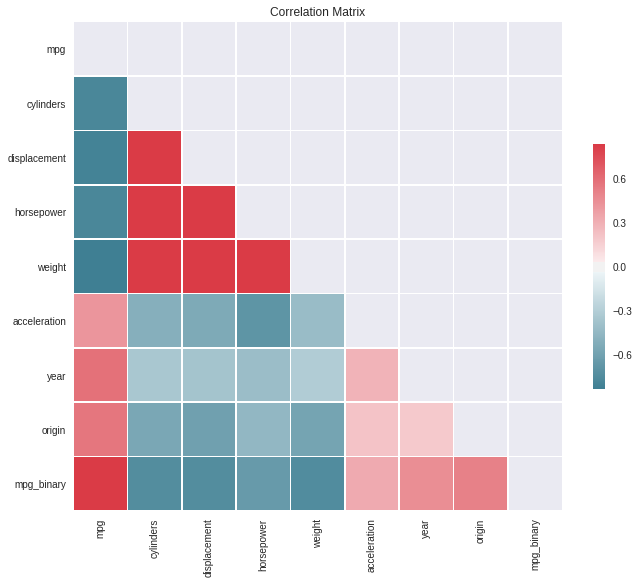

In [14]:
corr = clean_df.corr()
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3,
            square=True, xticklabels=corr.columns.values, yticklabels=corr.columns.values,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

ax.set_title('Correlation Matrix')

### Visualizing the Relationships Between mpg_binary and Other Variables

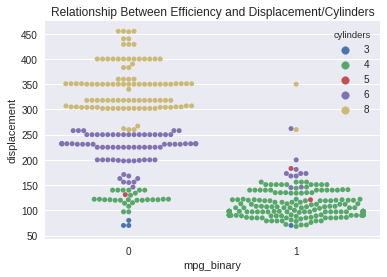

In [15]:
'''
In this plot, we see that cars with above median gas mileage are overwhelmingly 
more likely to have only 4 cylinders. It also appears that most of the efficient
cars have a displacement below 200.
'''
bx = sns.swarmplot(y= "displacement", x="mpg_binary", hue="cylinders", data=clean_df);
bx.set_title("Relationship Between Efficiency and Displacement/Cylinders")

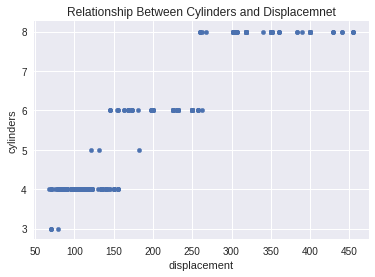

In [16]:
'''
This graph explores the relationship between cylinders and displacement a bit more. 
It makes sense that the more cylinders you have, the more volume would be displaced.
Given this, I would expect both variables to be useful predictors. However, they would 
be providing much the same information.
'''
ax = clean_df.plot(kind='scatter', x="displacement", y="cylinders")
ax.set_title("Relationship Between Cylinders and Displacemnet")

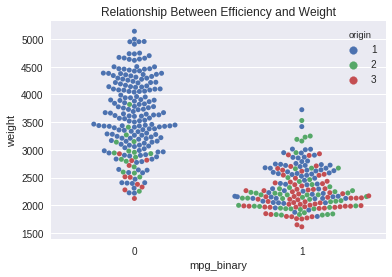

In [17]:
'''
Here, we see that most cars with above median gas mileage are under 3000 pounds.
It also appears that efficient cars are of mixed origin. However, inefficient cars
are more than likely to be of origin 1.
'''
ax = sns.swarmplot(y="weight", x="mpg_binary", hue="origin", data=clean_df)
ax.set_title("Relationship Between Efficiency and Weight")

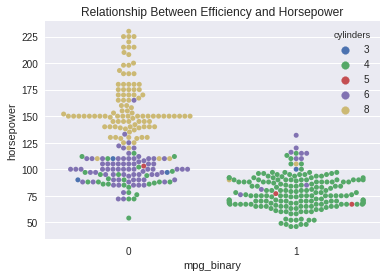

In [18]:
'''
Again, in this graph, we see that efficient cars have relatively low horsepower, with most
being below 100. We also see, unsurprisingly, that there is a relatinship between horsepower
and cylinders, with fewer cylinders corresponding to lower horsepower.
'''
ax = sns.swarmplot(y="horsepower", x="mpg_binary", hue="cylinders", data=clean_df)
ax.set_title("Relationship Between Efficiency and Horsepower")

### Conclusion
***Horsepower***, ***cylinders***, ***weight***, and ***displacement*** seem to be likely candidates for useful predictors.

However, from the correlation table, we see they are also all highly correlated with one another. Therefore, while these variables might prove useful, they might all be accounting for the same information.

Categorical variables such as ***origin*** could provide additional lift.

## Part C
Split the data into a training set and a test set.

### Adding Dummy Variables
Certain models such as decision trees are unable to take categorical variables. To fix this, we'll add a separate binary column for each category. A row will be assigned a 1 if it falls in that category, and 0 otherwise.

In [19]:
def add_dummies(df, col):
    '''
    Takes a dataframe and a column (string)
    Returns a new dataframe with columns added for each category 
    and the original column removed.
    '''
    # Each new column is prefixed with the first 4 letters of the original column
    dummy_df = pd.get_dummies(df[col], prefix=col[0:4])
    df.drop(col, axis=1, inplace=True)
    return pd.concat([df, dummy_df], axis=1)

In [20]:
discrete_vars = ['make', 'cylinders', 'origin', 'year', 'name', 'basic_model', "full_model"]

for column in discrete_vars:
    clean_df = add_dummies(clean_df, column)

In [21]:
# There are 848 features in the final dataframe that will be used for modeling
clean_df.columns

Index(['mpg', 'displacement', 'horsepower', 'weight', 'acceleration',
       'mpg_binary', 'make_amc', 'make_audi', 'make_bmw', 'make_buick',
       ...
       'full_vega 2300', 'full_ventura sj', 'full_vista cruiser',
       'full_volare', 'full_volare custom', 'full_volare premier v8',
       'full_woody', 'full_x1.9', 'full_zephyr', 'full_zephyr 6'],
      dtype='object', length=850)

### Splitting into Testing and Training Sets
For each model run, data set is randomly split three times using Stratified K-Fold into a training set and test set, with 1/3 in testing and 2/3 in training.

In [22]:
'''
Here, I separate the columns into X, the dependent variable (mpg_binary) 
and y, the features (predictors). I remove mpg_binary and mpg from the feature set.
Later on, I use StratifiedKFold to randomly split the rows in test (33.33%) and train (66.67%) sets.
I use StratifiedKFold instead of regular KFold because it maintains the percentage of samples for each class.
More: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html
'''
X, y = clean_df.drop(['mpg_binary', 'mpg'], axis=1), clean_df['mpg_binary']

## Part D
Perform two of the following in order to predict mpg_binary:

- LDA (Linear discriminant analysis)
- QDA (Quadratic discriminant analysis)
- Logistic regression
- KNN (K-nearest neighbors)
- Decision Tree
- Random Forests
- Gradient Boosting
- LASSO (Least Absolute Shrinkage and Selection Operator)
- Elastic Net Method
- Ridge regression analysis

For each of the two you select: What is the test error(s) of the model obtained? Do you have any other observations?

### Modeling

In this section, I use scikit-learn (sklearn) to perform predictions using the classifiers Random Forest (RF), Logistic Regression (LR), Gradient Bosting (GB), and Decision Trees (DT). 

First, I built models using only DT and LR because I felt that those were good baseline models. Both provide relatively fast and accurate predictions for binary classification. Additionally, neither of these models rely on geometric distance (unlike KNN), so there was no need to normalize the features. 

However, after I created my Model class and looping code, it was easy to add additional classifiers, so I added Gradient Boosting and Random Forests, which both build on Decision Trees.

For each model, I built a dictionary of possible parameters (stored in model_grid). Using sklearn's Parameter Grid, I was able to iterate over every possible combination of parameters for each classifier.

In [23]:
#classifiers to run through
clfs = {'RF': RandomForestClassifier(n_estimators = 50, n_jobs = -1),
        'LR': LogisticRegression(penalty = 'l1', C = 1e5),
        'GB': GradientBoostingClassifier(learning_rate = 0.05, subsample = 0.5, max_depth = 6, n_estimators = 10),
        'DT': DecisionTreeClassifier()
        }

#parameters to run through for each classifier. params are common params derived from the sklearn documentation.
model_grid = {
        'DT': {'criterion': ['gini', 'entropy'], 
               'max_depth': [1, 2, 15,20,30,40,50], 
               'max_features': ['sqrt','log2'],
               'min_samples_split': [2,5,10], 
               'random_state': [1]},
        'LR': {'penalty': ['l1','l2'], 
               'C': [0.00001,0.0001,0.001,0.01,0.1,1,10], 
               'random_state': [1]},
        'RF': {'n_estimators': [1,10,100,1000], 
              'max_depth': [10,15,20,30,40,50], 
              'max_features': ['sqrt','log2'],
              'min_samples_split': [2,5,10], 
              'random_state': [1]},
        'GB': {'n_estimators': [1,10,100,1000], 
               'learning_rate' : [0.001,0.01,0.05,0.1,0.5],
               'subsample' : [0.1,0.5,1.0], 
               'max_depth': [1,3,5,10,20,50,100],
               'random_state': [1]}
         }

In [24]:
from collections import defaultdict

class Model():
    '''
    A class to store and perform models using sklearn.
    '''
    def __init__(self, clf, model_id, model_type, params, n_splits, X, y):
        '''
        Inputs: 
                clf: sklearn classifier object
                model_id (string): a string to identify the model
                model_type (string): type of classifier (e.g. DT, LR, GB, etc.)
                params (dict): dictionary of parameters to pass to a model
                n_splits (int): number of splits to perform for cross validation
                X (pandas dataframe): dataframe containing features for each row
                y (pandas dataframe/series): dependent variable. Same number of rows as X
        '''
        self.model_id = model_id
        self.model_type = model_type
        self.params = params
        self.n_splits = n_splits
        self.X = X
        self.y = y
        self.clf = clf.set_params(**self.params)
        # Using Startified K Fold to generate test/train splits for cross-validation
        # Preserves the percentage of samples for each class.
        self.skf = StratifiedKFold(n_splits=n_splits)
        
        ######################################################
        ## Attributes to store model properties and results ##
        ######################################################
        # A nested dict: {loop (int): {threshold (float stored as string): {scorename (string): score}}}
        self.results_by_split = {} 
        # A nested dict: {threshold (float stored as string): {metric (string): [list of floats]}}
        self.results_by_metric = defaultdict(self._dict_list)
        # A nested dict
        self.feature_importances_by_split = {}
    
    ####################
    ## Public Methods ##
    ####################
    
    def cross_validate(self):
        '''
        Generates a test/train set for n_splits and fits the model. 
        Stores scores and feature importances for each model.
        '''
        for i, (train_index, test_index) in enumerate(self.skf.split(self.X, self.y)):
            X_train, X_test = X.loc[train_index], X.loc[test_index]
            y_train, y_test = y[train_index], y[test_index]
            fit = self.clf.fit(X_train, y_train)
            scores = self._score_model(fit, X_test, y_test)
            fit = self.clf.fit(X_train, y_train)
            self.results_by_split[i + 1] = scores
            columns = X_train.columns
            self.feature_importances_by_split[i + 1] = self.get_feature_importances(columns)
            
        self._set_results_by_metric()
    
    def get_feature_importances(self, columns, n=10):
        '''
        Input:  Takes a list or series of representing column names.
        Output: Returns a list of tuples containing the top n best features, sorted by feature importance score.
                Tuple contains (score (float), feature_name(string)).
        '''
        if self.model_type == 'LR':
            importances = self.clf.coef_[0]

        else:
            importances = self.clf.feature_importances_
        
        return sorted(list(zip(importances, list(columns))), reverse=True)[:n]
    
    def get_feature_rows(self):
        '''
        Input:  None
        Output: Returns a list of dictionaries. Each dictionary represents a row.
                Can be used to store data to CSV, SQL, Mongo, etc.
                E.g. of dictionary:
                    {'model_id': (String) model identifier,
                     'model_type': (String) model type (e.g. DT, LR, etc.),
                     'parameters': (String) a dictionary represented as a string containing the model's parameters,
                     'rank': (Int) represents ranked importances for a given split/model),
                     'score': (Float) feature importance score or coef,
                     'feature' (String) name of feature/column,
                     'split': (Int) the test/train split iteration of the model, up to n_splits}
        '''
        rows = []
        for split, importances in self.feature_importances_by_split.items():
            for i, (score, feature) in enumerate(importances):
                this_feature = self.get_model_info_dict()
                this_feature['rank'] = i + 1
                this_feature['score'] = score
                this_feature['feature'] = feature
                this_feature['split'] = split
                rows.append(this_feature)
        return rows
            
    def get_avg_results(self):
        '''
        Output: Returns a dictionary of metrics with average scores for each split/iteration 
                over a range of thresholds.
        '''
        results = {}
        for threshold, metrics in self.results_by_metric.items():
            avg_scores = {}
            for metric, scores in metrics.items():
                avg_scores['{}_avg'.format(metric)] = np.mean(scores)
                avg_scores['{}_std'.format(metric)] = np.std(scores)
            results[threshold] = avg_scores
        return results
    
    def get_eval_rows(self):
        '''
        Output: Returns a list of dictionaries (rows) for a evaluation of the model overall. 
                Includes the performance metrics averaged over n_splits splits at different thresholds.
                e.g. {'model_id': (String) model identifier,
                     'model_type': (String) model type (e.g. DT, LR, etc.),
                     'parameters': (String) a dictionary represented as a string containing the model's parameters,
                     'rank': (Int) represents ranked importances for a given split/model),
                     'score': (Float) feature importance score or coef,
                     'feature' (String) name of feature/column,
                     'split': (Int) the test/train split iteration of the model, up to n_splits
                }
        '''
        results = self.get_avg_results()
        rows = []
        for threshold in sorted(results.keys()):
            row = self.get_model_info_dict()
            row.update(results[threshold])
            row.update(self.params)
            row['threshold'] = threshold
            rows.append(row)
        return rows
    
    def get_split_rows(self):
        '''
        Output: Returns a list of dictionaries (rows) for each run of the model.
                Includes the performance metrics for each split, unaveraged, at different thresholds.
                Output is similar to get_eval_rows(), with n_splits times as many rows.
        '''
        rows = []
        for split, results in self.results_by_split.items():
            for threshold in sorted(results.keys()):
                row = self.get_model_info_dict()
                row.update(results[threshold])
                row['threshold'] = threshold
                row['split'] = split
                rows.append(row)
        return rows
    
    def get_model_info_dict(self):
        '''
        Output: Returns a dict with basic model information.
        '''
        return {'model_id': self.model_id,
                'model_type': self.model_type,
                'params': str(self.params)}
    
    #####################
    ## Private Methods ##
    #####################
                
    def _dict_list(self):
        '''
        Helper function for constructing dictionaries.
        Output: Returns a defaultdict initialized with a list.
        '''
        return defaultdict(list)
            
    
    def _set_results_by_metric(self):
        '''
        Takes results stored in self.results_by_split and reorganizes the dictionary by metric.
        Resulting dictionary is stored in self.results_by_metric.
        '''
        for thresholds in self.results_by_split.values():
            for threshold, metrics in thresholds.items():
                for metric, result in metrics.items():
                    self.results_by_metric[threshold][metric].append(result)
                    
    def _score_model(self, fit, X_test, y_test):
        '''
        Gets class probabilities. Uses them to calculate performance metrics.
        Input:  Takes sklearn fit object, X_test (pandas dataframe), y_test(pandas dataframe or series)
        Output: Returns a dictionary of performance metrics at thresholds 0.5, 0.6, 0.7, 0.8, and 0.9
        '''
        y_pred = fit.predict(X_test)
        y_prob = fit.predict_proba(X_test)[:,1]
        scores = self._get_scores_for_range(y_test, y_prob)
        return scores

    def _get_scores_for_range(self, y_test, y_prob, lower=.5, upper=1.0, step=.1):
        '''
        Input:  y_test (pandas dataframe or series)
                y_prob(list or pandas series)
                lower: lower threshold for range (float, inclusive). default is 0.5
                upper: upper threshold for range (float, non-inclusive). default is 1.0
                step: step to create range with (float). default is 0.1
                
        Output: Returns dictionary of performance metrics at threholds from lower to upper by step.
                Default thresholds are: [0.5, 0.6, 0.7, 0.8, 0.9]
                Metrics returned by default art: precision, recall, accuracy, roc_auc
        '''
        scores = {}
        roc_auc = roc_auc_score(y_test, y_prob)
        for threshold in np.arange(lower, upper, step):
            precision, recall, accuracy = self._get_scores_at_threshold(y_test, y_prob, threshold)
            scores[str(threshold)] = {'roc_auc': roc_auc, 'precision': precision, 'recall': recall, 'accuracy': accuracy}
        return scores

    def _get_scores_at_threshold(self, y_true, y_prob, threshold):
        '''
        Input:  y_true (list or pandas series) - actual values
                y_prob (list or pandas series) - probability of being in positive class
                threshold (float) - threshold at which to calculate performance metrics
                
        Output: Returns three scores (floats) for precision, recall, and accuracy
                Uses methods from sklearn.metrics
        '''
        y_pred = np.asarray([1 if i >= threshold else 0 for i in y_prob])
        return precision_score(y_true, y_pred), recall_score(y_true, y_pred), accuracy_score(y_true, y_pred)

In [25]:
'''
In this cell, I'm iterating over the classifiers and parameter combinations. 
I'm creating a Model object for each classifier/parameter and saving the results to CSVs.
'''

def run_param_loop(model, loop_count, X, y, clf, n_splits):
    '''
    Creates a Model object for each set of paraemeters.
    Input:  model (string) - represents model type, e.g. 'DT'
            loop_count (int) - 
            X (dataframe) - features/predictors
            y (dataframes or series) - predicted or dependent variable
            clf - sklearn classifier
            n_splits (int) - number of test/train splits to do for cross validation
            
    Output: Returns three lists of dictionaries. Each dictionaries represents a row.
            eval_rows returns rows for the performance of each model averaged over the n_split test/train splits
            split_rows returns rows for the performnace of each individual model at each split
            feat_rows returns for the top 10 features for each model and split
    '''
    model_id = "{}_paramset-{}".format(model, loop_count)
    model = Model(clf, model_id, model, params, n_splits, X, y)
    model.cross_validate()
    eval_rows = model.get_eval_rows()
    feat_rows = model.get_feature_rows()
    split_rows = model.get_split_rows()
    return eval_rows, split_rows, feat_rows

for model in clfs:
    '''
    Creating CSV's and looping over classifiers.
    '''
    print('Started running {}.'.format(model))
    with open('{}/models.csv'.format(model), 'w') as f, open('{}/splits.csv'.format(model), 'w') as g, open('{}/features.csv'.format(model), 'w') as h:
        eval_fieldnames = (['model_id', 'model_type', 'params', 'threshold'] + 
                           list(model_grid[model].keys()) +
                           ['roc_auc_avg', 'roc_auc_std', 'accuracy_avg', 'accuracy_std',
                           'precision_avg', 'precision_std', 'recall_avg', 'recall_std'])

        split_fieldnames = ['model_id', 'model_type', 'params', 'split', 'threshold',
                            'roc_auc', 'accuracy', 'precision', 'recall']
        
        feat_fieldnames = ['model_id', 'model_type', 'params', 'split', 'feature', 'score', 'rank']

        evalWriter = csv.DictWriter(f, fieldnames=eval_fieldnames)
        splitWriter = csv.DictWriter(g, fieldnames=split_fieldnames)
        featWriter = csv.DictWriter(h, fieldnames=feat_fieldnames)

        evalWriter.writeheader()
        splitWriter.writeheader()
        featWriter.writeheader()

        grid = ParameterGrid(model_grid[model])
        
        try:
            for i, params in enumerate(grid):
                evals, splits, feats = run_param_loop(model, i+1, X, y, clfs[model], 3)
                evalWriter.writerows(evals)
                splitWriter.writerows(splits)
                featWriter.writerows(feats)
        finally:
            print('Finished Running Model Type {}. Number of Models Run: {}'.format(model, i + 1))

Started running DT.
Finished Running Model Type DT. Number of Models Run: 84
Started running RF.
Finished Running Model Type RF. Number of Models Run: 144
Started running GB.
Finished Running Model Type GB. Number of Models Run: 420
Started running LR.
Finished Running Model Type LR. Number of Models Run: 14


## Results

In [26]:
def get_top_features(path, models=None, by_mean=True, n=10):
    '''
    '''
    df = pd.read_csv('{}features.csv'.format(path))
    if models is not None:
        df = df[df['model_id'].isin(models)]
        
    features = df.groupby('feature').agg(['count', 'mean'])
    
    if by_mean:
        return features.sort_values(('score', 'mean'), ascending=False).head(10)['score']
    return features.sort_values(('score', 'count'), ascending=False).head(10)['score']
    

def get_top_models(path, metric, n=10):
    df = pd.read_csv('{}models.csv'.format(path))
    top_models = df.sort_values(metric, ascending=False).head(n)
    model_names = top_models['model_id'].unique()
    return top_models, model_names
    

In [27]:
from glob import glob
from IPython.display import display, Markdown

paths = glob('*/')
for path in paths:
    top_models, model_names = get_top_models(path, 'accuracy_avg')
    display(Markdown('### Results for Model {}'.format(path.strip('/'))))
    display(Markdown('#### Top 10 Models'))
    display(top_models)
    display(Markdown('#### Top 10 Most Important Features by Mean Importance'))
    display(get_top_features(path, model_names))
    display(Markdown('#### Top 10 Most Important Features by Count'))
    display(get_top_features(path, model_names, by_mean=False))

### Results for Model RF

#### Top 10 Models

,model_id,model_type,params,threshold,min_samples_split,random_state,max_depth,n_estimators,max_features,roc_auc_avg,roc_auc_std,accuracy_avg,accuracy_std,precision_avg,precision_std,recall_avg,recall_std
370,RF_paramset-75,RF,"{'min_samples_split': 2, 'random_state': 1, 'm...",0.5,2,1,30,100,sqrt,0.931139,0.013620,0.896707,0.003978,0.872646,0.020518,0.921214,0.034673
255,RF_paramset-52,RF,"{'min_samples_split': 2, 'random_state': 1, 'm...",0.5,2,1,20,1000,sqrt,0.933287,0.016366,0.894239,0.010299,0.868413,0.025500,0.921296,0.026227
365,RF_paramset-74,RF,"{'min_samples_split': 2, 'random_state': 1, 'm...",0.5,2,1,30,10,sqrt,0.935099,0.006774,0.894201,0.006186,0.860437,0.011892,0.931796,0.027049
610,RF_paramset-123,RF,"{'min_samples_split': 2, 'random_state': 1, 'm...",0.5,2,1,50,100,sqrt,0.929987,0.012975,0.894163,0.006854,0.871268,0.012288,0.916005,0.030398
250,RF_paramset-51,RF,"{'min_samples_split': 2, 'random_state': 1, 'm...",0.5,2,1,20,100,sqrt,0.930566,0.009729,0.894163,0.011061,0.867865,0.017341,0.921214,0.034673
490,RF_paramset-99,RF,"{'min_samples_split': 2, 'random_state': 1, 'm...",0.5,2,1,40,100,sqrt,0.929987,0.012975,0.894163,0.006854,0.871268,0.012288,0.916005,0.030398
375,RF_paramset-76,RF,"{'min_samples_split': 2, 'random_state': 1, 'm...",0.5,2,1,30,1000,sqrt,0.933825,0.016207,0.891695,0.009264,0.867884,0.024779,0.916005,0.032967
615,RF_paramset-124,RF,"{'min_samples_split': 2, 'random_state': 1, 'm...",0.5,2,1,50,1000,sqrt,0.933823,0.016166,0.891695,0.009264,0.867884,0.024779,0.916005,0.032967
495,RF_paramset-100,RF,"{'min_samples_split': 2, 'random_state': 1, 'm...",0.5,2,1,40,1000,sqrt,0.933785,0.016149,0.891695,0.009264,0.867884,0.024779,0.916005,0.032967
605,RF_paramset-122,RF,"{'min_samples_split': 2, 'random_state': 1, 'm...",0.5,2,1,50,10,sqrt,0.934891,0.003470,0.891618,0.010200,0.855999,0.005055,0.931713,0.032859


#### Top 10 Most Important Features by Mean Importance

,count,mean
feature,,
displacement,30,0.127124
cyli_4,30,0.109381
weight,30,0.107791
horsepower,30,0.094188
cyli_8,30,0.045792
orig_1,25,0.036025
acceleration,29,0.035821
cyli_6,28,0.029743
orig_2,2,0.026245


#### Top 10 Most Important Features by Count

,count,mean
feature,,
cyli_4,30,0.109381
cyli_8,30,0.045792
displacement,30,0.127124
horsepower,30,0.094188
weight,30,0.107791
acceleration,29,0.035821
cyli_6,28,0.029743
orig_1,25,0.036025
orig_3,20,0.025183


### Results for Model DT

#### Top 10 Models

,model_id,model_type,params,threshold,criterion,min_samples_split,random_state,max_depth,max_features,roc_auc_avg,roc_auc_std,accuracy_avg,accuracy_std,precision_avg,precision_std,recall_avg,recall_std
171,DT_paramset-35,DT,"{'criterion': 'gini', 'min_samples_split': 5, ...",0.6,gini,5,1,40,log2,0.907813,0.005251,0.869177,0.027100,0.860027,0.022187,0.869296,0.040573
201,DT_paramset-41,DT,"{'criterion': 'gini', 'min_samples_split': 5, ...",0.6,gini,5,1,50,log2,0.907813,0.005251,0.869177,0.027100,0.860027,0.022187,0.869296,0.040573
200,DT_paramset-41,DT,"{'criterion': 'gini', 'min_samples_split': 5, ...",0.5,gini,5,1,50,log2,0.907813,0.005251,0.869024,0.015371,0.829954,0.010191,0.916336,0.052987
170,DT_paramset-35,DT,"{'criterion': 'gini', 'min_samples_split': 5, ...",0.5,gini,5,1,40,log2,0.907813,0.005251,0.869024,0.015371,0.829954,0.010191,0.916336,0.052987
136,DT_paramset-28,DT,"{'criterion': 'gini', 'min_samples_split': 2, ...",0.6,gini,2,1,30,log2,0.853551,0.020582,0.868985,0.007623,0.864864,0.019007,0.863674,0.027808
345,DT_paramset-70,DT,"{'criterion': 'entropy', 'min_samples_split': ...",0.5,entropy,2,1,30,log2,0.853551,0.020582,0.868985,0.007623,0.864864,0.019007,0.863674,0.027808
346,DT_paramset-70,DT,"{'criterion': 'entropy', 'min_samples_split': ...",0.6,entropy,2,1,30,log2,0.853551,0.020582,0.868985,0.007623,0.864864,0.019007,0.863674,0.027808
135,DT_paramset-28,DT,"{'criterion': 'gini', 'min_samples_split': 2, ...",0.5,gini,2,1,30,log2,0.853551,0.020582,0.868985,0.007623,0.864864,0.019007,0.863674,0.027808
172,DT_paramset-35,DT,"{'criterion': 'gini', 'min_samples_split': 5, ...",0.7,gini,5,1,40,log2,0.907813,0.005251,0.864164,0.027469,0.858496,0.022921,0.858879,0.037667
202,DT_paramset-41,DT,"{'criterion': 'gini', 'min_samples_split': 5, ...",0.7,gini,5,1,50,log2,0.907813,0.005251,0.864164,0.027469,0.858496,0.022921,0.858879,0.037667


#### Top 10 Most Important Features by Mean Importance

,count,mean
feature,,
orig_1,12,0.196540
displacement,6,0.163497
weight,10,0.159045
orig_2,4,0.118796
cyli_4,12,0.103850
year_82,3,0.083331
cyli_6,2,0.060108
horsepower,4,0.047494
basi_corolla,4,0.043112


#### Top 10 Most Important Features by Count

,count,mean
feature,,
cyli_4,12,0.103850
orig_1,12,0.196540
acceleration,10,0.039619
weight,10,0.159045
year_73,6,0.042303
displacement,6,0.163497
horsepower,4,0.047494
year_76,4,0.017163
basi_civic,4,0.025541


### Results for Model GB

#### Top 10 Models

,model_id,model_type,params,threshold,subsample,learning_rate,random_state,max_depth,n_estimators,roc_auc_avg,roc_auc_std,accuracy_avg,accuracy_std,precision_avg,precision_std,recall_avg,recall_std
1174,GB_paramset-235,GB,"{'subsample': 0.1, 'learning_rate': 0.05, 'ran...",0.9,0.1,0.05,1,50,100,0.952450,0.012660,0.896707,0.015555,0.896294,0.023996,0.889798,0.046848
1234,GB_paramset-247,GB,"{'subsample': 0.1, 'learning_rate': 0.05, 'ran...",0.9,0.1,0.05,1,100,100,0.952450,0.012660,0.896707,0.015555,0.896294,0.023996,0.889798,0.046848
1114,GB_paramset-223,GB,"{'subsample': 0.1, 'learning_rate': 0.05, 'ran...",0.9,0.1,0.05,1,20,100,0.952450,0.012660,0.896707,0.015555,0.896294,0.023996,0.889798,0.046848
875,GB_paramset-176,GB,"{'subsample': 0.5, 'learning_rate': 0.05, 'ran...",0.5,0.5,0.05,1,1,100,0.950992,0.009739,0.896669,0.010005,0.872751,0.019336,0.921131,0.047011
1425,GB_paramset-286,GB,"{'subsample': 0.1, 'learning_rate': 0.1, 'rand...",0.5,0.1,0.10,1,5,1000,0.940583,0.010163,0.894239,0.010299,0.876866,0.034123,0.910797,0.027466
1426,GB_paramset-286,GB,"{'subsample': 0.1, 'learning_rate': 0.1, 'rand...",0.6,0.1,0.10,1,5,1000,0.940583,0.010163,0.894239,0.016026,0.880531,0.036241,0.905589,0.023032
1474,GB_paramset-295,GB,"{'subsample': 0.1, 'learning_rate': 0.1, 'rand...",0.9,0.1,0.10,1,10,100,0.947737,0.018843,0.894239,0.021976,0.880844,0.035982,0.905506,0.056243
1233,GB_paramset-247,GB,"{'subsample': 0.1, 'learning_rate': 0.05, 'ran...",0.8,0.1,0.05,1,100,100,0.952450,0.012660,0.894201,0.018433,0.876358,0.030565,0.910714,0.045673
1113,GB_paramset-223,GB,"{'subsample': 0.1, 'learning_rate': 0.05, 'ran...",0.8,0.1,0.05,1,20,100,0.952450,0.012660,0.894201,0.018433,0.876358,0.030565,0.910714,0.045673
1173,GB_paramset-235,GB,"{'subsample': 0.1, 'learning_rate': 0.05, 'ran...",0.8,0.1,0.05,1,50,100,0.952450,0.012660,0.894201,0.018433,0.876358,0.030565,0.910714,0.045673


#### Top 10 Most Important Features by Mean Importance

,count,mean
feature,,
displacement,15,0.121140
weight,15,0.111107
horsepower,14,0.070158
year_79,1,0.070000
year_73,6,0.063049
cyli_4,13,0.054175
year_72,10,0.051717
acceleration,15,0.051515
full_maverick,2,0.044772


#### Top 10 Most Important Features by Count

,count,mean
feature,,
acceleration,15,0.051515
weight,15,0.111107
displacement,15,0.121140
horsepower,14,0.070158
cyli_4,13,0.054175
basi_vega,11,0.028623
year_72,10,0.051717
basi_cutlass,7,0.032486
basi_pinto,7,0.030951


### Results for Model LR

#### Top 10 Models

,model_id,model_type,params,threshold,C,random_state,penalty,roc_auc_avg,roc_auc_std,accuracy_avg,accuracy_std,precision_avg,precision_std,recall_avg,recall_std
20,LR_paramset-5,LR,"{'C': 0.001, 'random_state': 1, 'penalty': 'l1'}",0.5,0.00100,1,l1,0.879217,0.035876,0.878972,0.027385,0.832779,0.028645,0.937004,0.026125
5,LR_paramset-2,LR,"{'C': 1e-05, 'random_state': 1, 'penalty': 'l2'}",0.5,0.00001,1,l2,0.881594,0.034841,0.876351,0.034876,0.837514,0.027621,0.921131,0.047011
15,LR_paramset-4,LR,"{'C': 0.0001, 'random_state': 1, 'penalty': 'l2'}",0.5,0.00010,1,l2,0.880148,0.035409,0.873960,0.020396,0.824804,0.017390,0.937004,0.026125
30,LR_paramset-7,LR,"{'C': 0.01, 'random_state': 1, 'penalty': 'l1'}",0.5,0.01000,1,l1,0.884732,0.037205,0.873921,0.022458,0.827609,0.015917,0.931713,0.032859
25,LR_paramset-6,LR,"{'C': 0.001, 'random_state': 1, 'penalty': 'l2'}",0.5,0.00100,1,l2,0.889103,0.032620,0.873883,0.028635,0.827364,0.017784,0.931630,0.045651
45,LR_paramset-10,LR,"{'C': 0.1, 'random_state': 1, 'penalty': 'l2'}",0.5,0.10000,1,l2,0.924875,0.009245,0.869024,0.015371,0.846523,0.019394,0.889881,0.034452
35,LR_paramset-8,LR,"{'C': 0.01, 'random_state': 1, 'penalty': 'l2'}",0.5,0.01000,1,l2,0.917572,0.016746,0.866364,0.030962,0.825030,0.019313,0.915923,0.052391
40,LR_paramset-9,LR,"{'C': 0.1, 'random_state': 1, 'penalty': 'l1'}",0.5,0.10000,1,l1,0.920003,0.013817,0.858769,0.032425,0.825367,0.016950,0.894924,0.058603
55,LR_paramset-12,LR,"{'C': 1, 'random_state': 1, 'penalty': 'l2'}",0.5,1.00000,1,l2,0.917269,0.013710,0.856416,0.018446,0.834819,0.014229,0.874339,0.025533
46,LR_paramset-10,LR,"{'C': 0.1, 'random_state': 1, 'penalty': 'l2'}",0.6,0.10000,1,l2,0.924875,0.009245,0.853795,0.028969,0.851834,0.009336,0.842593,0.068590


#### Top 10 Most Important Features by Mean Importance

,count,mean
feature,,
full_citation,1,0.555160
basi_citation,1,0.555160
name_chevrolet citation,1,0.555160
name_oldsmobile cutlass ls,1,0.452260
basi_colt,1,0.404223
make_oldsmobile,10,0.291632
basi_cutlass,6,0.279507
cyli_4,18,0.275788
make_dodge,2,0.264531


#### Top 10 Most Important Features by Count

,count,mean
feature,,
year_80,24,0.166164
year_82,21,0.191594
year_81,21,0.209944
year_79,20,0.149834
acceleration,20,0.164378
cyli_4,18,0.275788
year_77,15,0.056281
orig_3,15,0.065085
year_78,15,0.065915


### Conclusion
#### Model Performance
Because we used the median to create the binary label, we should have roughly equal classes. In fact, roughly 48.1% of the rows were positively labeled, and 51.9% were negatively labeled. Thus, if we achieve an accuracy better than 50%, our models are at least performing better than random.

That's good news, because the top 3 performing models all sported an accuracy of 0.897. Because we're not worried about class imbalance, accuracy is a robust measure of model performance. Of the top 3, one used random forest and two  used gradient boosting. However, the gradient boosting models eeked out a slighter better ROC_AUC with 0.952, versus 0.931 for random forest. That means the gradient boosting models achieved a better tradeoff between [precision and recall](https://en.wikipedia.org/wiki/Precision_and_recall) over different thresholds.

It's interesting to note that of the best performing GB models used thresholds of 0.9. That means the model only classified the car as efficient if it were had more than a 90% probability of being efficient. Conversely, all of the top performing RF models used a threshold of 0.5.

While RF and GB performed the best, DT and LR still had respectable performances with accuracies of 0.869 and 0.970 respectively.

The performance metrics for the top 2 performing models from each classifier:

Model Name| roc_auc_avg | roc_auc_std | accuracy_avg | accuracy_std | precision_avg | precision_std | recall_avg | recall_std
---|---|---|---|---|---|---|---
RF_paramset-75 | 0.931139 | 0.013620 | 0.896707 | 0.003978 | 0.872646 | 0.020518 | 0.921214 | 0.034673
RF_paramset-52 | 0.933287 | 0.016366 | 0.894239 | 0.010299 | 0.868413 | 0.025500 | 0.921296 | 0.026227
DT_paramset-35 | 0.907813 | 0.005251 | 0.869177 | 0.027100 | 0.860027 | 0.022187 | 0.869296 | 0.040573
DT_paramset-41 | 0.907813 | 0.005251 | 0.869177 | 0.027100 | 0.860027 | 0.022187 | 0.869296 | 0.040573
GB_paramset-235 | 0.952450 | 0.012660 | 0.896707 | 0.015555 | 0.896294 | 0.023996 | 0.889798 | 0.046848
GB_paramset-247 | 0.952450 | 0.012660 | 0.896707 | 0.015555 | 0.896294 | 0.023996 | 0.889798 | 0.046848
LR_paramset-5 | 0.879217 | 0.035876 | 0.878972 | 0.027385 | 0.832779 | 0.028645 | 0.937004 | 0.026125
LR_paramset-2 | 0.881594 | 0.034841 | 0.876351 | 0.034876 | 0.837514 | 0.027621 | 0.921131 | 0.047011

#### Concerns
One major concern for this project was overfitting. Because there were so few cars of any given make and model, it's possible that you could perfectly predict a car's mileage based on those fields. To help remedy this, I limited the max depth for DT and RF to 50 out of 848 total features.  

#### Feature Importances
I also looked at the top features for the best performing models, both by frequency of occurence (how often a feature showed up as important) and the average of their feature importance scores.

As expected, displacement, weight, horsepower, and acceleration frequently showed up in the top 10. The number of cylinders, origin, and the year 73 also appear to be significant features. I took a closer look below at the mean and standard deviation of gas mileage by year. Cars from 1973 had both the worst mileage and the least standard deviation, meaning that cars from that year were reliably below the median.

Interesting, LR relied much more on make and year than did the other 3 classifiers.

In [28]:
rows = []
for year in df['year'].unique():
    sub_df = df[df['year'] == year]
    rows.append((year, sub_df['mpg'].mean(), sub_df['mpg'].std()))
pd.DataFrame(rows, columns=['year', 'mean mpg', 'std mpg'])

,year,mean mpg,std mpg
0,70,17.689655,5.339231
1,71,21.250000,6.591942
2,72,18.714286,5.435529
3,73,17.100000,4.700245
4,74,22.703704,6.420010
5,75,20.266667,4.940566
6,76,21.573529,5.889297
7,77,23.375000,6.675862
8,78,24.061111,6.898044
9,79,25.093103,6.794217
